# Tomato Disease Detection

## 1. Filter image duplication
Check the image duplication in the same folder than the duplicate will be deleted.

In [1]:
import os
from PIL import Image
import imagehash
from tqdm import tqdm
import shutil

# === CONFIGURATION ===
DATASET_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato/Tomato_Full_Dataset"  # directory data source
HASH_FUNC = imagehash.phash
THRESHOLD = 5                          # 0 = exact match, 1–5 = similar images allowed
DELETE_DUPLICATES = True
BACKUP_DUPLICATES = False              # move duplicates to backup instead of deleting

# === IMPLEMENTATION ===
def remove_duplicates_in_folder(folder_path):
    hash_to_file = {}
    duplicates = []

    image_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    for filepath in image_files:
        try:
            img = Image.open(filepath)
            img_hash = HASH_FUNC(img)
        except Exception as e:
            print(f"Skipping {filepath}: {e}")
            continue

        found = False
        for existing_hash in hash_to_file:
            if abs(img_hash - existing_hash) <= THRESHOLD:
                duplicates.append((filepath, hash_to_file[existing_hash]))
                found = True
                break

        if not found:
            hash_to_file[img_hash] = filepath

    if DELETE_DUPLICATES and duplicates:
        if BACKUP_DUPLICATES:
            backup_dir = os.path.join(folder_path, "_duplicates_backup")
            os.makedirs(backup_dir, exist_ok=True)

        for dup, keep in duplicates:
            try:
                if BACKUP_DUPLICATES:
                    shutil.move(dup, os.path.join(backup_dir, os.path.basename(dup)))
                else:
                    os.remove(dup)
            except Exception as e:
                print(f"Error deleting {dup}: {e}")

    return len(duplicates)


def find_and_remove_duplicates_within_folders(root_folder):
    class_folders = [
        os.path.join(root_folder, d)
        for d in os.listdir(root_folder)
        if os.path.isdir(os.path.join(root_folder, d))
    ]

    total_deleted = 0
    for class_folder in tqdm(class_folders, desc="Processing folders"):
        num_deleted = remove_duplicates_in_folder(class_folder)
        print(f"{os.path.basename(class_folder)} — removed {num_deleted} duplicates.")
        total_deleted += num_deleted

    print(f"\nFinished. Total duplicates removed: {total_deleted}")


# === RUN ===
if __name__ == "__main__":
    find_and_remove_duplicates_within_folders(DATASET_DIR)

Processing folders:  10%|█         | 1/10 [00:18<02:46, 18.55s/it]

bacterial_spot — removed 0 duplicates.


Processing folders:  20%|██        | 2/10 [00:25<01:35, 11.88s/it]

early_blight — removed 0 duplicates.


Processing folders:  30%|███       | 3/10 [00:39<01:28, 12.71s/it]

healthy — removed 0 duplicates.


Processing folders:  40%|████      | 4/10 [00:53<01:20, 13.43s/it]

late_blight — removed 0 duplicates.


Processing folders:  50%|█████     | 5/10 [01:01<00:57, 11.47s/it]

leaf_mold — removed 0 duplicates.


Processing folders:  60%|██████    | 6/10 [01:09<00:40, 10.00s/it]

mosaic_virus — removed 0 duplicates.


Processing folders:  70%|███████   | 7/10 [01:22<00:33, 11.26s/it]

septoria_leaf_spot — removed 0 duplicates.


Processing folders:  80%|████████  | 8/10 [01:32<00:21, 10.73s/it]

target_spot — removed 0 duplicates.


Processing folders:  90%|█████████ | 9/10 [01:45<00:11, 11.35s/it]

two_spotted_spider_mite — removed 0 duplicates.


Processing folders: 100%|██████████| 10/10 [02:31<00:00, 15.13s/it]

yellow_leaf_curl_virus — removed 0 duplicates.

Finished. Total duplicates removed: 0


## 2. Infected and health leaves category distribution

Scanning folders: 11it [00:00, 286.23it/s]



 Category distribution:

               Category  Image Count
 yellow_leaf_curl_virus         4197
         bacterial_spot         2122
            late_blight         1904
     septoria_leaf_spot         1780
                healthy         1748
two_spotted_spider_mite         1671
            target_spot         1432
              leaf_mold         1132
           early_blight         1131
           mosaic_virus          971


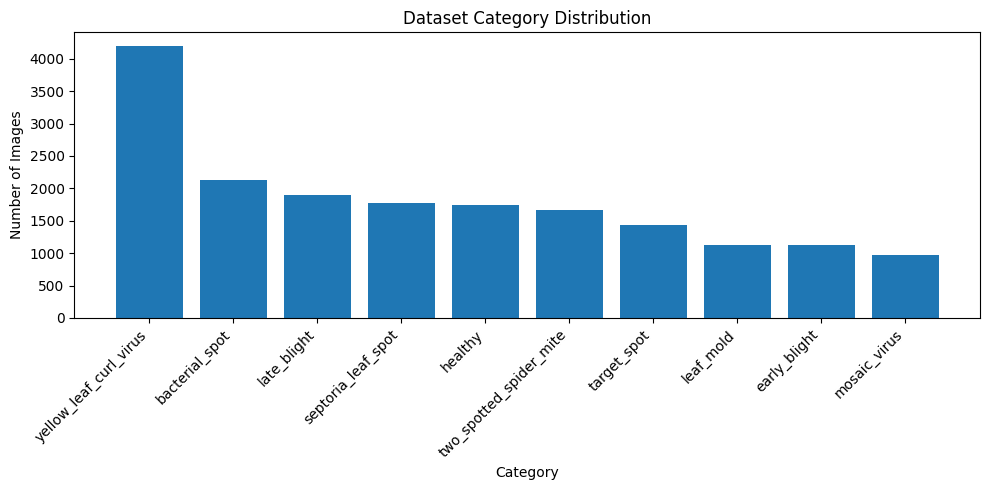

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === CONFIGURATION ===
#DATASET_DIR = "path_to_your_dataset"  # e.g. "./dataset"
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

# === IMPLEMENTATION ===
def get_category_distribution(root_folder):
    category_counts = {}

    # Loop through all subfolders
    for root, dirs, files in tqdm(os.walk(root_folder), desc="Scanning folders"):
        # Only count files if this folder directly contains images
        image_files = [f for f in files if f.lower().endswith(VALID_EXTENSIONS)]
        if image_files:
            # Folder name (class label)
            label = os.path.basename(root)
            category_counts[label] = category_counts.get(label, 0) + len(image_files)

    # Convert to DataFrame for better formatting
    df = pd.DataFrame(list(category_counts.items()), columns=["Category", "Image Count"])
    df = df.sort_values("Image Count", ascending=False).reset_index(drop=True)

    return df

def plot_distribution(df, title="Dataset Category Distribution"):
    plt.figure(figsize=(10, 5))
    plt.bar(df["Category"], df["Image Count"])
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()


# === RUN ===
if __name__ == "__main__":
    df = get_category_distribution(DATASET_DIR)
    print("\n Category distribution:\n")
    print(df.to_string(index=False))

    plot_distribution(df)

Result: there is imbalance dataset, so that we will use balancing technique so that the minority target will not be discriminated.

## 3. Call all libraries required

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')

## 4. Data preparation

In [4]:
DATASET_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato/Tomato_Full_Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2 expects [-1, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

Found 14474 images belonging to 10 classes.
Found 3614 images belonging to 10 classes.


## 5. Compute class weight for imbalance correction

In [5]:
labels = train_gen.classes
classes = np.unique(labels)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.852414605418139), 1: np.float64(1.5993370165745857), 2: np.float64(1.0345961401000714), 3: np.float64(0.9497375328083989), 4: np.float64(1.5975717439293597), 5: np.float64(1.8628056628056628), 6: np.float64(1.0164325842696629), 7: np.float64(1.263001745200698), 8: np.float64(1.0825729244577411), 9: np.float64(0.43103037522334725)}


## 6. Model setup for MobileNetV2

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze base initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 7. Callback

In [7]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
ckpt = ModelCheckpoint('best_mobilenetv2_tomato.keras',
                       monitor='val_accuracy',
                       save_best_only=True,
                       verbose=1)

## 8. Train base model (frozen)

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[es, ckpt]
)

C:\Users\ekadw\anaconda3\envs\Tensorflow31018\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.3461 - loss: 2.0141  
Epoch 1: val_accuracy improved from -inf to 0.76619, saving model to best_mobilenetv2_tomato.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 374s 817ms/step - accuracy: 0.3464 - loss: 2.0131 - val_accuracy: 0.7662 - val_loss: 0.7952
Epoch 2/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6837 - loss: 1.0228  
Epoch 2: val_accuracy improved from 0.76619 to 0.81876, saving model to best_mobilenetv2_tomato.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 373s 823ms/step - accuracy: 0.6838 - loss: 1.0227 - val_accuracy: 0.8188 - val_loss: 0.5933
Epoch 3/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.7505 - loss: 0.8144  
Epoch 3: val_accuracy improved from 0.81876 to 0.84975, saving model to best_mobilenetv2_tomato.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 382s 844ms/step - accuracy: 0.7505 - loss: 0.8144 - val_accuracy: 0.8498 - val_loss: 0.4899
Epoch 4/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy

## 9. Fine tunning (unfreeze top layers)

In [9]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[es, ckpt]
)

Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.6404 - loss: 1.2980  
Epoch 1: val_accuracy did not improve from 0.91146
453/453 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.6406 - loss: 1.2971 - val_accuracy: 0.8794 - val_loss: 0.3565
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8334 - loss: 0.5235  
Epoch 2: val_accuracy did not improve from 0.91146
453/453 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.8334 - loss: 0.5234 - val_accuracy: 0.8882 - val_loss: 0.3191
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8598 - loss: 0.4419  
Epoch 3: val_accuracy did not improve from 0.91146
453/453 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.8599 - loss: 0.4418 - val_accuracy: 0.8996 - val_loss: 0.2939
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8865 - loss: 0.3688  
Epoch 4: val_accuracy improved from 0.91146 to 0.91395, saving model to best_mobilenetv2_tomato.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 50

## 10. Evaluation

In [10]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n Validation Accuracy after fine-tuning: {val_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 76s 672ms/step - accuracy: 0.9449 - loss: 0.1700 

 Validation Accuracy after fine-tuning: 0.9507


## 11. Plot training vs validation accuracy

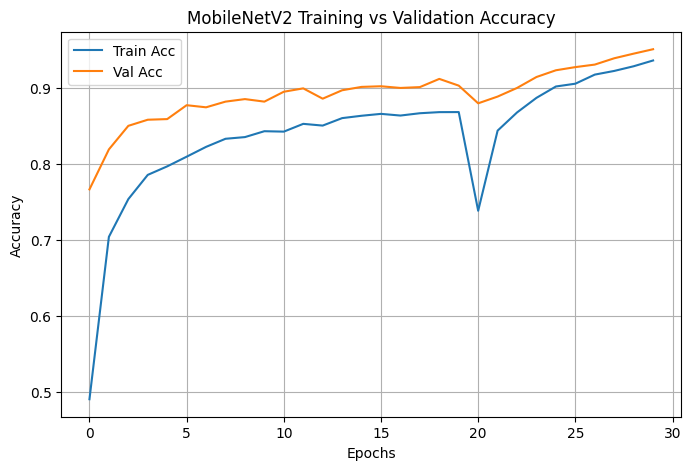

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'] + fine_history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + fine_history.history['val_accuracy'], label='Val Acc')
plt.title("MobileNetV2 Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 12. Save and Load model

In [12]:
# save model:
# ModelCheckpoint('best_mobilenetv2_tomato.keras', save_best_only=True)

# load model:
#from tensorflow.keras.models import load_model
#model = load_model("best_mobilenetv2_tomato.keras")